In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import pickle

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import DateType, StringType, FloatType, StructType, StructField

from sklearn.metrics import recall_score, brier_score_loss

import model_monitoring

In [ ]:
# Build a .py script that generates model metrics and save to datamart (gold)

## Set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("model_monitoring") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/24 07:21:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# these will be arguments passed by Airflow
snapshot_date_str = "2024-01-01" # ds (month of monitoring)
model_name = "credit_model_2024_09_01.pkl" # model to evaluate against

In [4]:
config = {}
config["snapshot_date_str"] = snapshot_date_str
config["snapshot_date"] = datetime.strptime(config["snapshot_date_str"], "%Y-%m-%d")
config["model_name"] = model_name
config["model_bank_directory"] = "model_bank/"
config["model_psi_ref_preds_filepath"] = config["model_bank_directory"] + config["model_name"][:-4] + "_psi_ref_preds.parquet"

pprint.pprint(config)

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 1, 1, 0, 0),
 'snapshot_date_str': '2024-01-01'}


## fetch baseline month for PSI computation using `model_name`

In [6]:
psi_ref_sdf = spark.read.parquet(config["model_psi_ref_preds_filepath"])
print("psi_ref_df row_count:",psi_ref_sdf.count())

psi_ref_sdf.show(5)

psi_ref_df row_count: 498
+-----------+-------------+--------------------+-------------------+
|Customer_ID|snapshot_date|          model_name|  model_predictions|
+-----------+-------------+--------------------+-------------------+
| CUS_0xbf2e|   2024-06-01|credit_model_2024...|0.11080322414636612|
| CUS_0xbf67|   2024-06-01|credit_model_2024...|0.07106562703847885|
| CUS_0xbf9a|   2024-06-01|credit_model_2024...| 0.5223297476768494|
| CUS_0xc016|   2024-06-01|credit_model_2024...|0.16164369881153107|
| CUS_0xc02d|   2024-06-01|credit_model_2024...|0.12054947763681412|
+-----------+-------------+--------------------+-------------------+
only showing top 5 rows



## fetch predictions and labels for `snapshot_date_str`

For model evaluation, the tricky part is:
* The inference happens at the month of loan start (or loan application date) 
* the labels only appear at Month on Book (MOB) = 6. (snapshot_date_str + 6 months)

So for example
* CUS_0x1000 applies for loan on 2023_05_01. We get his information from this month and make an inference
* Label for CUS_0x1000 appears only on 2023_11_01

Our labels only appear from 2023_07_01. So in this scenario, for 2024_01_01, we fetch the predictions our model made 6 months ago to check back.

In [7]:
# format date properly
formatted_date = config["snapshot_date_str"].replace('-', '_')

In [8]:
# Fetch the labels first
# If no label yet, or label count = 0, exit task
label_directory =  "datamart/gold/label_store/"
filename = f"gold_label_store_{formatted_date}.parquet"
file_path = os.path.join(label_directory, filename)

try:
    label_sdf = spark.read.parquet(file_path)
    print("label_sdf row_count:",label_sdf.count())

    if label_sdf.count() == 0:
        print(f'Zero label data for {formatted_date}, exiting flow')
        # do early return here

except Exception as e:
    print(f'No label data file for {formatted_date}, exiting flow')

label_sdf row_count: 471


In [9]:
# Compute date 6 months ago and format this date
past_date = config["snapshot_date"] - relativedelta(months=6)
formatted_past_date = past_date.strftime("%Y_%m_%d")
formatted_past_date

'2023_07_01'

In [10]:
# Fetch predictions
model_pred_directory = f"datamart/gold/model_predictions/{config['model_name'][:-4]}/"
filename = f"{config['model_name'][:-4]}_preds_{formatted_past_date}.parquet"
file_path = os.path.join(model_pred_directory, filename)

model_pred_sdf = spark.read.parquet(file_path)
print("model_pred_sdf row_count:",model_pred_sdf.count())

model_pred_sdf row_count: 471


## extract required fields

In [11]:
# Match prediction to label for each Customer_ID so that both in order
pred_label_sdf = label_sdf.select([col(c) for c in label_sdf.columns]) # make a fresh copy of one table
pred_label_sdf = pred_label_sdf.join(model_pred_sdf, on="Customer_ID", how="inner")

# Check size of resultant table. 
print(f"pred_label_sdf row_count: {pred_label_sdf.count()}")

pred_label_sdf row_count: 471


In [12]:
# Convert to pandas df
psi_ref_df = psi_ref_sdf.toPandas()
pred_label_df = pred_label_sdf.toPandas()

In [32]:
# Extract relevant data
y_pred_proba = pred_label_df['model_predictions']
y_pred = (y_pred_proba >= 0.5).astype(int) # Assume threshold 0.5
y_true = pred_label_df['label']
y_pred_proba_ref = psi_ref_df['model_predictions']

## compute metrics

In [33]:
def calculate_psi(y_pred_proba_ref, y_pred_proba, buckets=10):
    """
    Calculate the Population Stability Index (PSI) between two distributions.
    Parameters:
        y_pred_proba_ref: reference distribution of model prediction
        y_pred_proba: current distribution of model prediction (for that month)
        buckets: number of quantile bins to split the scores. Default 10 for 10% buckets in classification probabilities
    Returns:
        psi_value: float
    """
    def get_bin_proportions(values, breakpoints):
        counts, _ = np.histogram(values, bins=breakpoints)
        return counts / len(values)

    # Extract proba values at 0, 10, 20..., 100th pctile from y_pred_ref
    breakpoints = np.percentile(y_pred_proba_ref, np.linspace(0, 100, buckets + 1))
    breakpoints[0] = -np.inf  # handle outliers below 0
    breakpoints[-1] = np.inf # handle outliers above 1

    expected_percents = get_bin_proportions(y_pred_proba_ref, breakpoints)
    actual_percents = get_bin_proportions(y_pred_proba, breakpoints)

    # Avoid division by zero or log(0) by giving those with 0 some value
    expected_percents = np.where(expected_percents == 0, 1e-6, expected_percents)
    actual_percents = np.where(actual_percents == 0, 1e-6, actual_percents)

    psi = np.sum((expected_percents - actual_percents) * np.log(expected_percents / actual_percents))

    return psi

In [34]:
# Recall
recall = recall_score(y_true, y_pred, pos_label=1)
print('recall: ', recall)

# Brier Score
brier = brier_score_loss(y_true, y_pred_proba)  # proba for class 1
print('brier score:', brier)

# Population Stability Index
psi = calculate_psi(y_pred_proba_ref, y_pred_proba)
print('Population stability index:', psi)

recall:  0.5642857142857143
brier score: 0.14195083304832215
Population stability index: 0.027492894464298367


## save model metrics to `model_metrics_tab`

In [42]:
# Define schema of correct data types
column_type_map = StructType([
    StructField("snapshot_date", DateType(), True),
    StructField("model_version", StringType(), True),
    StructField("recall", FloatType(), True),
    StructField("brier_score", FloatType(), True),
    StructField("psi", FloatType(), True)
])

# Create spark dataframe to store results
results_row = {
    "snapshot_date": config["snapshot_date"],
    "model_version": str(config['model_name']),
    "recall": float(recall),
    "brier_score": float(brier),
    "psi": float(psi)
}

# Create df with schema enforced
metrics_df = spark.createDataFrame([results_row], schema=column_type_map)

In [49]:
# Create directory
gold_metrics_directory = "datamart/gold/model_metrics/"
if not os.path.exists(gold_metrics_directory):
    os.makedirs(gold_metrics_directory)

# Concat path
metrics_table_path = f"{gold_metrics_directory}gold_metrics_tab.parquet"

# Check if table exists
if not os.path.exists(metrics_table_path):
    # create table and save
    metrics_df.write.mode("overwrite").parquet(metrics_table_path)
    print('created gold metrics table and saved results_row')
else:
    # read existing table
    existing_df = spark.read.parquet(metrics_table_path)
    
    # Union and drop duplicates
    combined_df = existing_df.unionByName(metrics_df)
    combined_df = combined_df.dropDuplicates(["snapshot_date", "model_version"])
    
    # Overwrite table with deduplicated data
    combined_df.write.mode("overwrite").parquet(metrics_table_path)
    print("Updated and deduplicated (if applicable) gold metrics table")

Updated and deduplicated (if applicable) gold metrics table


## manually run script to generate model monitoring metrics for each month

In [2]:
# set up config
# snapshot_date_str = "2023-01-01"
# backfill for all 2 years of data given (regardless of whether labels have appeared yet)

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [3]:
# Specify model_name again (if you want to skip the Jupyter cell right at the top)
model_name = "credit_model_2024_09_01.pkl"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)

In [6]:
for snapshot_date in dates_str_lst:
    print('processing snapshot_date: ', snapshot_date)
    model_monitoring.main(snapshot_date, model_name)

processing snapshot_date:  2023-01-01

---starting job---



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/24 08:54:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2023, 1, 1, 0, 0),
 'snapshot_date_str': '2023-01-01'}
psi_ref_df row_count: 498
label_sdf row_count: 0
Zero label data for 2023_01_01, exiting flow
Stopping Spark session...
processing snapshot_date:  2023-02-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2023, 2, 1, 0, 0),
 'snapshot_date_str': '2023-02-01'}
psi_ref_df row_count: 498
label_sdf row_count: 0
Zero label data for 2023_02_01, exiting flow
Stopping Spark session...
processing snapshot_date:  2023-03-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_

Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2023-08-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2023, 8, 1, 0, 0),
 'snapshot_date_str': '2023-08-01'}
psi_ref_df row_count: 498
label_sdf row_count: 501
model_pred_sdf row_count: 501
pred_label_sdf row_count: 501
recall:  0.5
brier score: 0.14632265301415515
Population stability index: 0.017448223596969542


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2023-09-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2023, 9, 1, 0, 0),
 'snapshot_date_str': '2023-09-01'}
psi_ref_df row_count: 498
label_sdf row_count: 506
model_pred_sdf row_count: 506
pred_label_sdf row_count: 506
recall:  0.5617283950617284
brier score: 0.1389632185229582
Population stability index: 0.02302551432492441


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2023-10-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2023, 10, 1, 0, 0),
 'snapshot_date_str': '2023-10-01'}
psi_ref_df row_count: 498
label_sdf row_count: 510
model_pred_sdf row_count: 510
pred_label_sdf row_count: 510
recall:  0.5620437956204379
brier score: 0.12592929139312434
Population stability index: 0.0218819967691841


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2023-11-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2023, 11, 1, 0, 0),
 'snapshot_date_str': '2023-11-01'}
psi_ref_df row_count: 498
label_sdf row_count: 521
model_pred_sdf row_count: 521
pred_label_sdf row_count: 521
recall:  0.6762589928057554
brier score: 0.11070313920911229
Population stability index: 0.04481093025895003


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2023-12-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2023, 12, 1, 0, 0),
 'snapshot_date_str': '2023-12-01'}
psi_ref_df row_count: 498
label_sdf row_count: 517
model_pred_sdf row_count: 517
pred_label_sdf row_count: 517
recall:  0.5401459854014599
brier score: 0.1249294665243653
Population stability index: 0.024636293053547878


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-01-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 1, 1, 0, 0),
 'snapshot_date_str': '2024-01-01'}
psi_ref_df row_count: 498
label_sdf row_count: 471
model_pred_sdf row_count: 471
pred_label_sdf row_count: 471
recall:  0.5642857142857143
brier score: 0.14195083304832215
Population stability index: 0.027492894464298367


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-02-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 2, 1, 0, 0),
 'snapshot_date_str': '2024-02-01'}
psi_ref_df row_count: 498
label_sdf row_count: 481
model_pred_sdf row_count: 481
pred_label_sdf row_count: 481
recall:  0.6115107913669064
brier score: 0.12007649055332022
Population stability index: 0.04480922580862232


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-03-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 3, 1, 0, 0),
 'snapshot_date_str': '2024-03-01'}
psi_ref_df row_count: 498
label_sdf row_count: 454
model_pred_sdf row_count: 454
pred_label_sdf row_count: 454
recall:  0.5798319327731093
brier score: 0.12158051113718076
Population stability index: 0.01359694519845742


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-04-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 4, 1, 0, 0),
 'snapshot_date_str': '2024-04-01'}
psi_ref_df row_count: 498
label_sdf row_count: 487
model_pred_sdf row_count: 487
pred_label_sdf row_count: 487
recall:  0.632
brier score: 0.11818670604553164
Population stability index: 0.022752909091593797


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-05-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 5, 1, 0, 0),
 'snapshot_date_str': '2024-05-01'}
psi_ref_df row_count: 498
label_sdf row_count: 491
model_pred_sdf row_count: 491
pred_label_sdf row_count: 491
recall:  0.5734265734265734
brier score: 0.12924896799406815
Population stability index: 0.044811308582886095


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-06-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 6, 1, 0, 0),
 'snapshot_date_str': '2024-06-01'}
psi_ref_df row_count: 498
label_sdf row_count: 489
model_pred_sdf row_count: 489
pred_label_sdf row_count: 489
recall:  0.5761589403973509
brier score: 0.13207958260739788
Population stability index: 0.02802187141508889


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-07-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 7, 1, 0, 0),
 'snapshot_date_str': '2024-07-01'}
psi_ref_df row_count: 498
label_sdf row_count: 485
model_pred_sdf row_count: 485
pred_label_sdf row_count: 485
recall:  0.5
brier score: 0.15209686730845903
Population stability index: 0.018773103889344202


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-08-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 8, 1, 0, 0),
 'snapshot_date_str': '2024-08-01'}
psi_ref_df row_count: 498
label_sdf row_count: 518
model_pred_sdf row_count: 518
pred_label_sdf row_count: 518
recall:  0.54421768707483
brier score: 0.15789177811322985
Population stability index: 0.02187521389936209


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-09-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 9, 1, 0, 0),
 'snapshot_date_str': '2024-09-01'}
psi_ref_df row_count: 498
label_sdf row_count: 511
model_pred_sdf row_count: 511
pred_label_sdf row_count: 511
recall:  0.4880952380952381
brier score: 0.17374493191395943
Population stability index: 0.03337728589632887


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-10-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 10, 1, 0, 0),
 'snapshot_date_str': '2024-10-01'}
psi_ref_df row_count: 498
label_sdf row_count: 513
model_pred_sdf row_count: 513
pred_label_sdf row_count: 513
recall:  0.44366197183098594
brier score: 0.16972246730811746
Population stability index: 0.010571791357506


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-11-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 11, 1, 0, 0),
 'snapshot_date_str': '2024-11-01'}
psi_ref_df row_count: 498
label_sdf row_count: 491
model_pred_sdf row_count: 491
pred_label_sdf row_count: 491
recall:  0.47651006711409394
brier score: 0.15948902553239377
Population stability index: 0.025755265463921186


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...
processing snapshot_date:  2024-12-01

---starting job---

{'model_bank_directory': 'model_bank/',
 'model_name': 'credit_model_2024_09_01.pkl',
 'model_psi_ref_preds_filepath': 'model_bank/credit_model_2024_09_01_psi_ref_preds.parquet',
 'snapshot_date': datetime.datetime(2024, 12, 1, 0, 0),
 'snapshot_date_str': '2024-12-01'}
psi_ref_df row_count: 498
label_sdf row_count: 498
model_pred_sdf row_count: 498
pred_label_sdf row_count: 498
recall:  0.5161290322580645
brier score: 0.15482905172099293
Population stability index: 0.008279622569816224


Updated and deduplicated (if applicable) gold metrics table

---completed job---


Stopping Spark session...


## check datamart

The `model_monitoring.main()` function initialises a Spark session and stops it after processing each date's dataset. Therefore, as of above code completion, there is no active spark session.   

Therefore, we need to initialize a SparkSession again to check

In [7]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("model_metrics_datamart") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

In [8]:
file_path = "datamart/gold/model_metrics/gold_metrics_tab.parquet"
df = spark.read.parquet(file_path)
print("row_count:",df.count())

df.show()

row_count: 18
+-------------+--------------------+----------+-----------+------------+
|snapshot_date|       model_version|    recall|brier_score|         psi|
+-------------+--------------------+----------+-----------+------------+
|   2024-08-01|credit_model_2024...| 0.5442177| 0.15789178| 0.021875214|
|   2024-03-01|credit_model_2024...|0.57983196| 0.12158051| 0.013596945|
|   2024-11-01|credit_model_2024...|0.47651008| 0.15948902| 0.025755266|
|   2023-10-01|credit_model_2024...| 0.5620438|  0.1259293| 0.021881998|
|   2023-07-01|credit_model_2024...|0.54285717| 0.12266273|  0.05438805|
|   2023-12-01|credit_model_2024...|  0.540146|0.124929465| 0.024636293|
|   2024-10-01|credit_model_2024...|0.44366196| 0.16972247| 0.010571792|
|   2023-09-01|credit_model_2024...| 0.5617284| 0.13896322| 0.023025515|
|   2024-05-01|credit_model_2024...|0.57342654| 0.12924896|  0.04481131|
|   2024-01-01|credit_model_2024...| 0.5642857| 0.14195083| 0.027492894|
|   2024-09-01|credit_model_2024...|0

## Plot metrics data with charts

In [9]:
metrics_pdf = df.toPandas()

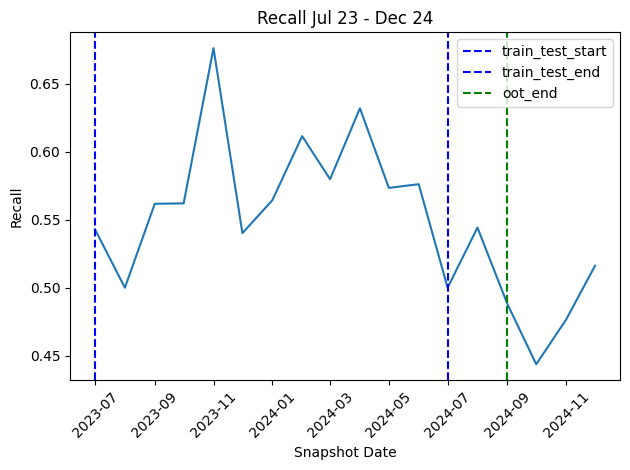

In [22]:
# recall
sns.lineplot(data=metrics_pdf, x="snapshot_date", y="recall")
plt.xticks(rotation=45)

# Time markers
plt.axvline(x=datetime(2023, 7, 1), color="blue", linestyle="--", label="train_test_start")
plt.axvline(x=datetime(2024, 7, 1), color="blue", linestyle="--", label="train_test_end")
plt.axvline(x=datetime(2024, 9, 1), color="green", linestyle="--", label="oot_end")

plt.xlabel('Snapshot Date')
plt.ylabel('Recall')
plt.title('Recall Jul 23 - Dec 24')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

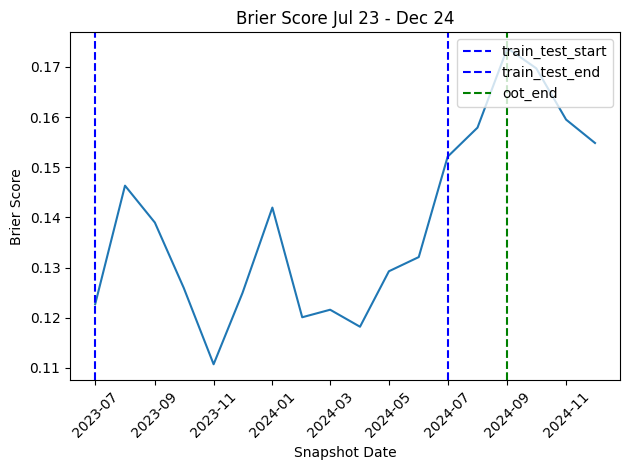

In [23]:
# brier_score
sns.lineplot(data=metrics_pdf, x="snapshot_date", y="brier_score")

# Time markers
plt.axvline(x=datetime(2023, 7, 1), color="blue", linestyle="--", label="train_test_start")
plt.axvline(x=datetime(2024, 7, 1), color="blue", linestyle="--", label="train_test_end")
plt.axvline(x=datetime(2024, 9, 1), color="green", linestyle="--", label="oot_end")

plt.xlabel('Snapshot Date')
plt.ylabel('Brier Score')
plt.title('Brier Score Jul 23 - Dec 24')
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

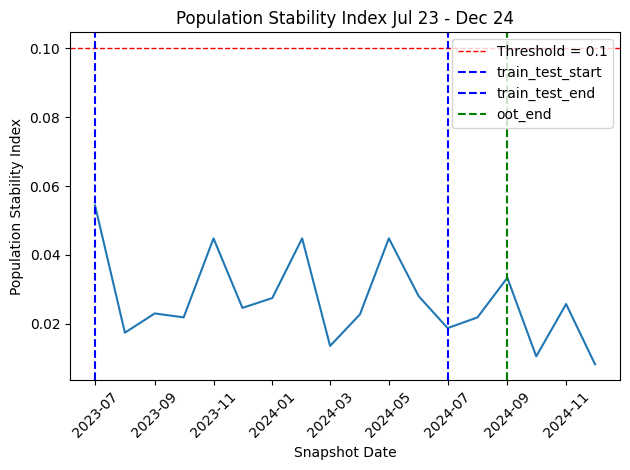

In [24]:
# psi
sns.lineplot(data=metrics_pdf, x="snapshot_date", y="psi")
plt.axhline(y=0.1, color='red', linestyle='--', linewidth=1, label='Threshold = 0.1')

# Time markers
plt.axvline(x=datetime(2023, 7, 1), color="blue", linestyle="--", label="train_test_start")
plt.axvline(x=datetime(2024, 7, 1), color="blue", linestyle="--", label="train_test_end")
plt.axvline(x=datetime(2024, 9, 1), color="green", linestyle="--", label="oot_end")

plt.xlabel('Snapshot Date')
plt.ylabel('Population Stability Index')
plt.title('Population Stability Index Jul 23 - Dec 24')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

## stop spark session

In [25]:
# Stop session after using
spark.stop()